In [ ]:
# Setup and Imports
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from IPython.display import Image, display

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Ensure project_root is defined for subsequent cells
print(f'Project Root: {project_root}')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(f"Using device: {device}")

# Common imports
from src.envs.synthetic_env import BouncingBallEnv
from src.envs.atari_env import AtariPixelEnv
# L-AGI Imports
from src.models.logical_spatial_rgm import LogicalSpatialRGM
from src.l_fep.activation import SphericalActivation
from src.l_fep.loss import LogicalDivergenceLoss
# We will define a simple wrapper for the agent and trainer in this notebook
# to demonstrate the L-AGI integration explicitly.


Project Root: /Users/yezune/ws/from_pixels_to_planning
Using device: cpu


objc[54244]: Class CaptureDelegate is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x11826e5d8) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_videoio.4.12.0.dylib (0x12cc14618). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[54244]: Class CVWindow is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x11826e628) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_highgui.4.12.0.dylib (0x12c514a70). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[54244]: Class CVView is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x11826e650) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_highgui.4.12.0.dylib (0x12c514a98). This may cause spu

# Experiment 3: Bouncing Ball

## 1. Bouncing Ball Experiment (Phase 4)

We train a Flat Active Inference Agent on the Bouncing Ball environment and visualize the VAE reconstruction.

Training VAE...


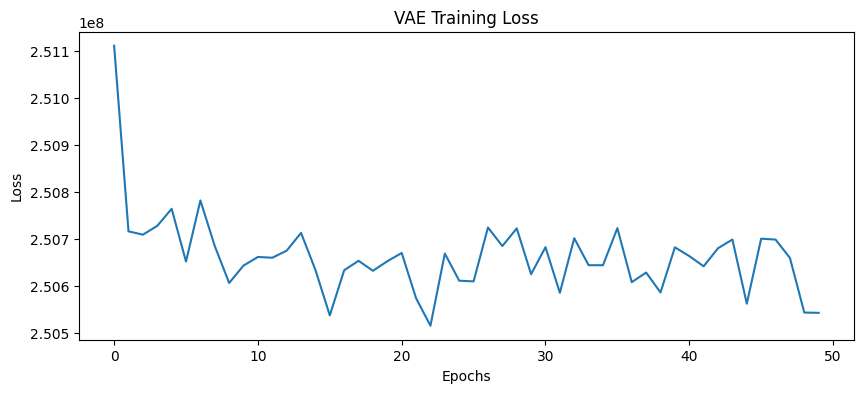

In [ ]:
# Initialize Environment
env = BouncingBallEnv(size=32)
obs_shape = (3, 32, 32)
action_dim = env.action_space.n

# Initialize L-AGI Model (Logical Spatial RGM)
# input_channels=3 for RGB Bouncing Ball
# latent_dim=32 (Standard for L-AGI experiments)
rgm = LogicalSpatialRGM(input_channels=3, latent_dim=32, num_classes=10, img_size=32).to(device)

# Optimizer
optimizer = torch.optim.Adam(rgm.parameters(), lr=1e-3)

# Data Collection (Random Walk)
print("Collecting data...")
buffer = []
obs, _ = env.reset()
for _ in range(2000): # Collect 2000 steps
    buffer.append(obs)
    action = env.action_space.sample()
    obs, _, _, _, _ = env.step(action)

# Convert buffer to Tensor and Normalize
data = np.array(buffer) # (N, 32, 32, 3)
data_tensor = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2).to(device) # (N, 3, 32, 32)
data_tensor = data_tensor / 255.0 # Normalize to [0, 1]

print(f"Data shape: {data_tensor.shape}")

# Training Loop
print("Training Logical Spatial RGM...")
batch_size = 32
epochs = 50
losses = []

rgm.train()
for epoch in range(epochs):
    perm = torch.randperm(data_tensor.size(0))
    epoch_loss = 0
    
    for i in range(0, data_tensor.size(0), batch_size):
        indices = perm[i:i+batch_size]
        batch = data_tensor[indices]
        
        optimizer.zero_grad()
        
        # Forward pass
        recon, z1, z2, z1_prior = rgm(batch)
        
        # Calculate Loss
        # We don't have labels for Bouncing Ball (unsupervised), so we ignore cls_loss
        total_loss, recon_loss, consistency_loss, _ = rgm.get_loss(recon, batch, z1, z1_prior, z2, labels=None)
        
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
        
    avg_loss = epoch_loss / (data_tensor.size(0) / batch_size)
    losses.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title("Logical Spatial RGM Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Wrap for compatibility with visualization functions
class LogicalAgentWrapper:
    def __init__(self, rgm):
        self.vae = rgm

agent = LogicalAgentWrapper(rgm)


Visualizing Sequence...


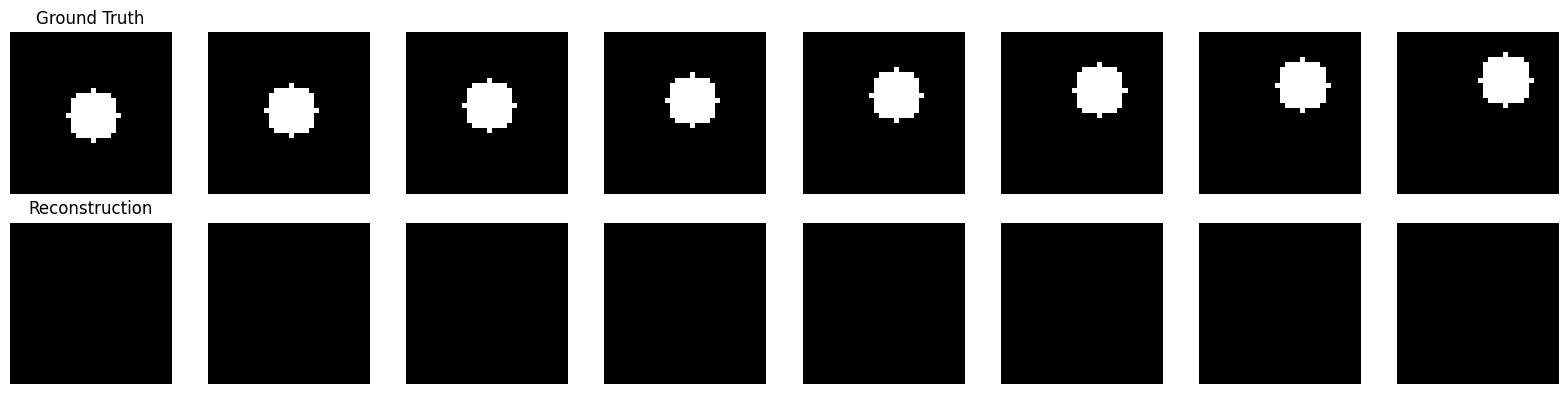

In [ ]:
# 1. Sequence Visualization (Trajectory Tracking)
# 공의 움직임(Trajectory)을 따라가며 원본과 재구성 이미지를 비교합니다.
def visualize_sequence(agent, env, num_steps=10):
    obs, _ = env.reset()
    
    originals = []
    reconstructions = []
    
    for _ in range(num_steps):
        # Process Observation
        if not isinstance(obs, torch.Tensor):
            obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device)
        else:
            obs_tensor = obs.to(device)
            
        if obs_tensor.shape[-1] == 3:
            obs_tensor = obs_tensor.permute(2, 0, 1)
        
        # Normalize to [0, 1]
        obs_tensor = obs_tensor / 255.0
        
        obs_tensor = obs_tensor.unsqueeze(0)
        
        # VAE Reconstruction
        with torch.no_grad():
            # LogicalSpatialRGM returns 4 values: recon, z1, z2, z1_prior
            recon, _, _, _ = agent.vae(obs_tensor)
            
        # Store images
        # Original is 0-255
        orig_img = obs.astype(np.uint8)
        
        # Recon is 0-1 (Sigmoid output), convert to 0-255
        recon_img = recon.squeeze().permute(1, 2, 0).cpu().numpy()
        recon_img = (recon_img * 255).clip(0, 255).astype(np.uint8)
        
        originals.append(orig_img)
        reconstructions.append(recon_img)
        
        # Step Env (Random Action for now)
        action = env.action_space.sample()
        obs, _, _, _, _ = env.step(action)

    # Plot
    fig, axes = plt.subplots(2, num_steps, figsize=(2 * num_steps, 4))
    for i in range(num_steps):
        axes[0, i].imshow(originals[i])
        axes[0, i].axis('off')
        if i == 0: axes[0, i].set_title("Ground Truth")
        
        axes[1, i].imshow(reconstructions[i])
        axes[1, i].axis('off')
        if i == 0: axes[1, i].set_title("Reconstruction")
    
    plt.tight_layout()
    plt.show()

print("Visualizing Sequence...")
visualize_sequence(agent, env, num_steps=8)


Generating Animation...
Animation saved to bouncing_ball.gif
Animation saved to bouncing_ball.gif


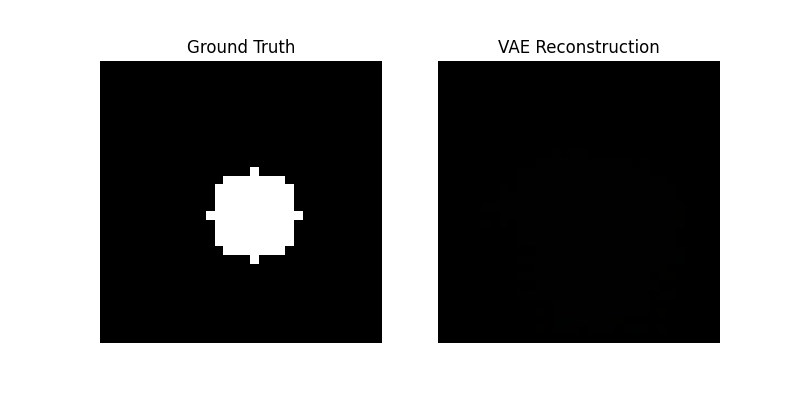

In [ ]:
# 2. Generate GIF Animation (Real-time Tracking)
# 공이 튀어 다니는 모습을 애니메이션으로 생성하여 모델의 실시간 처리 능력을 확인합니다.
import matplotlib.animation as animation

def create_animation(agent, env, num_frames=50, filename='bouncing_ball.gif'):
    obs, _ = env.reset()
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].set_title("Ground Truth")
    axes[1].set_title("Logical RGM Reconstruction")
    
    img1 = axes[0].imshow(np.zeros((32, 32, 3)), animated=True)
    img2 = axes[1].imshow(np.zeros((32, 32, 3)), animated=True)
    axes[0].axis('off')
    axes[1].axis('off')
    
    def update(frame):
        nonlocal obs
        # Process Observation
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device)
        if obs_tensor.shape[-1] == 3:
            obs_tensor = obs_tensor.permute(2, 0, 1)
            
        # Normalize to [0, 1]
        obs_tensor = obs_tensor / 255.0
        
        obs_tensor = obs_tensor.unsqueeze(0)
        
        with torch.no_grad():
            # LogicalSpatialRGM returns 4 values
            recon, _, _, _ = agent.vae(obs_tensor)
            
        orig_img = obs.astype(np.uint8)
        
        # Recon is 0-1, convert to 0-255
        recon_img = recon.squeeze().permute(1, 2, 0).cpu().numpy()
        recon_img = (recon_img * 255).clip(0, 255).astype(np.uint8)
        
        img1.set_array(orig_img)
        img2.set_array(recon_img)
        
        # Step
        action = env.action_space.sample()
        obs, _, _, _, _ = env.step(action)
        return img1, img2

    ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=True)
    ani.save(filename, writer='pillow', fps=15)
    plt.close()
    print(f"Animation saved to {filename}")
    return filename

print("Generating Animation...")
gif_path = create_animation(agent, env, num_frames=60)
display(Image(filename=gif_path))
